In [1]:
import pandas as pd
import pandas.io.sql as sqlio
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5, style="whitegrid")
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import numpy as np
from connector import getConnection

### Interest income distribution

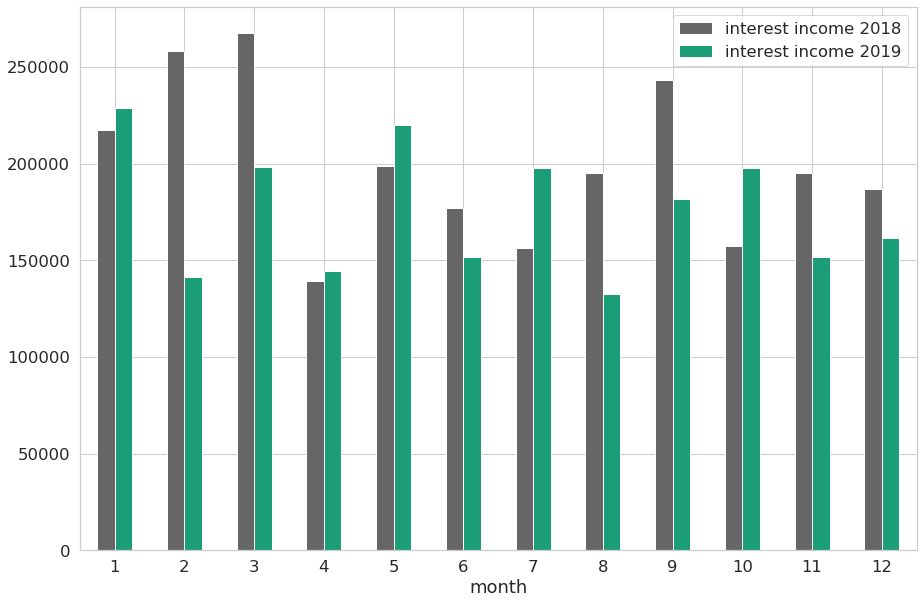

In [126]:
conn = getConnection()

sql = """WITH interest_income_query AS(SELECT  i.sale_date_key, SUM(i.interest) AS interest_income
FROM installment i
GROUP BY i.sale_date_key) 
SELECT iq_2018.month, ROUND(iq_2018.ii::numeric,2) as "interest income 2018",
ROUND(iq_2019.ii::numeric,2) as "interest income 2019"
FROM  
(SELECT d.month, SUM(q.interest_income) AS ii 
FROM public."date" d, interest_income_query q
WHERE d.date_key = q.sale_date_key AND d.year = 2018 
group by d.month) AS iq_2018, 
(SELECT d.month, SUM(q.interest_income) AS ii 
FROM public."date" d, interest_income_query q
WHERE d.date_key = q.sale_date_key AND d.year = 2019 
GROUP BY d.month) AS iq_2019 
WHERE iq_2018.month = iq_2019.month 
ORDER BY iq_2019.month """

df = sqlio.read_sql_query(sql, conn)
df.head()
conn.close()
df.plot(x="month", y=["interest income 2018", "interest income 2019"], kind="bar",figsize=(15,10), rot = 0, colormap= 'Dark2_r')


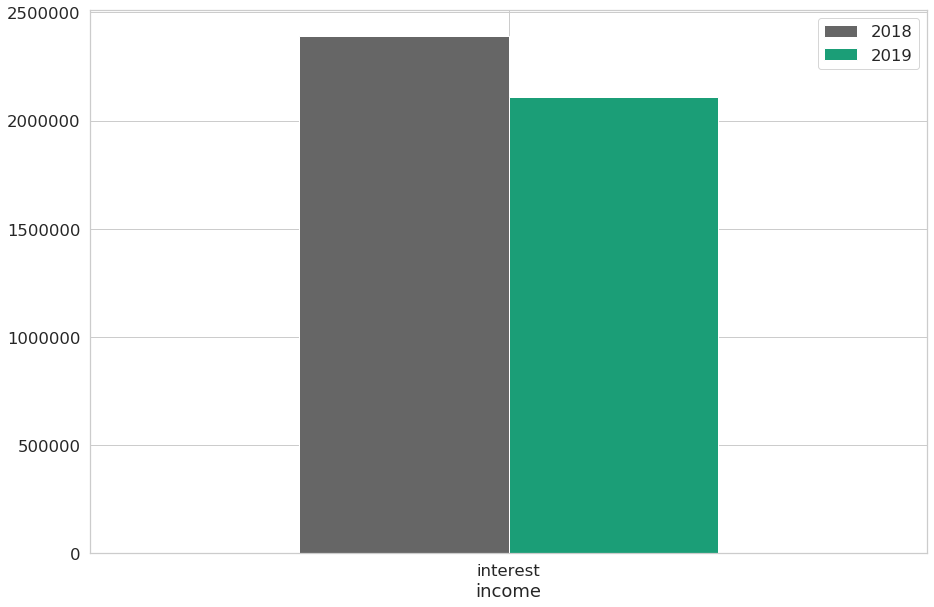

In [127]:
conn = getConnection()

sql = """WITH interest_income_query AS(SELECT  i.sale_date_key, SUM(i.interest) AS interest_income
FROM installment i
GROUP BY i.sale_date_key) 
SELECT 'interest' as income ,ROUND(iq_2018.ii::numeric,2) as "2018",
ROUND(iq_2019.ii::numeric,2) as "2019"
FROM  
(SELECT d.year, SUM(q.interest_income) AS ii 
FROM public."date" d, interest_income_query q
WHERE d.date_key = q.sale_date_key AND d.year = 2018 
group by d.year) AS iq_2018, 
(SELECT d.year, SUM(q.interest_income) AS ii 
FROM public."date" d, interest_income_query q
WHERE d.date_key = q.sale_date_key AND d.year = 2019 
GROUP BY d.year) AS iq_2019 
 """

df = sqlio.read_sql_query(sql, conn)
df = df.set_index('income')
conn.close()
df.head()
df.plot(y=["2018", "2019"], kind="bar",figsize=(15,10), rot = 0, colormap='Dark2_r')


### Best selling month

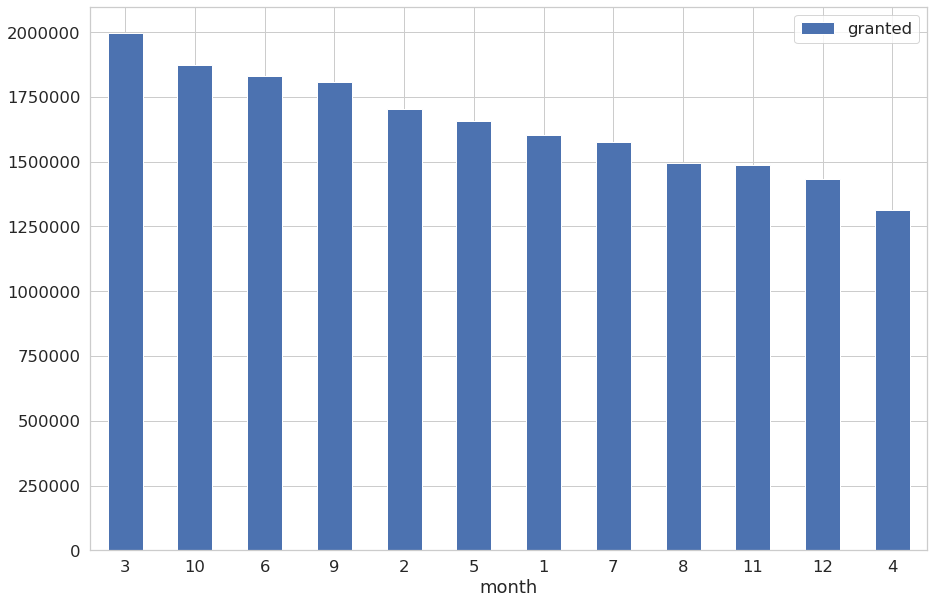

In [41]:
conn = getConnection()

sql = """SELECT d.month, SUM(s.loan_amount) as granted ,  
       RANK() OVER ( ORDER BY SUM(s.loan_amount) DESC ) best 
FROM sale s, public."date" d   
WHERE s.sale_date_key = d.date_key AND d.year = 2018 
GROUP BY  d.month; """

df = sqlio.read_sql_query(sql, conn)
df = df.set_index('month')
conn.close()
df.head()

df.plot.bar(y=['granted'],figsize=(15,10), rot = 0)

### Best 7 days period for sales

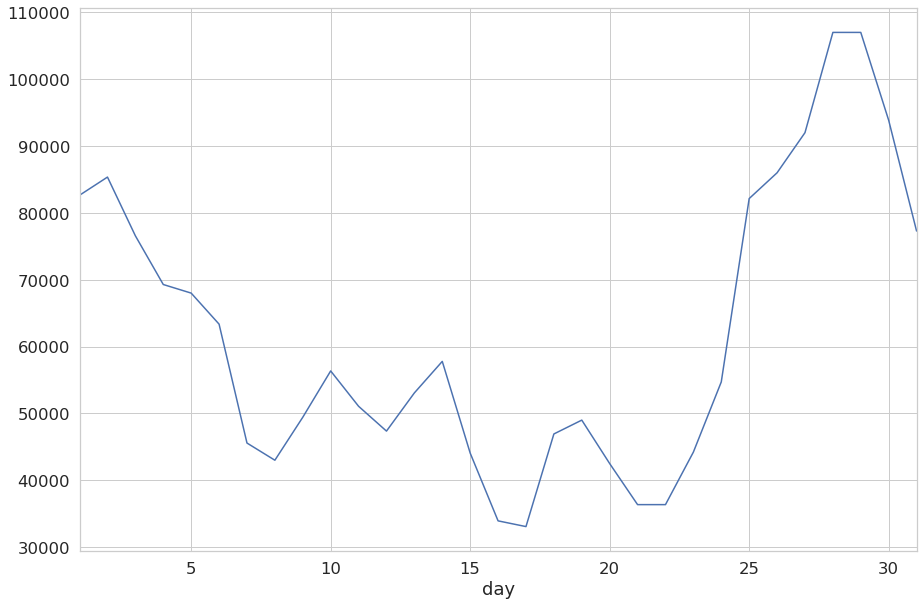

In [74]:
 
conn = getConnection()

sql = """SELECT iq.day, total_granted, week_total_sale_avg 
FROM  
(SELECT q1.date AS date, q1.month ,q1.day ,  
SUM(q1.loan_amount) AS total_granted,AVG(SUM(q1.loan_amount)) 
OVER ( ORDER BY q1.date_key ROWS BETWEEN 3 PRECEDING and 3 FOLLOWING ) AS week_total_sale_avg 
FROM  
(   
SELECT d.*, COALESCE(s.loan_amount ,0) AS loan_amount 
FROM 
public."date" d LEFT OUTER JOIN sale s 
ON d.date_key = s.sale_date_key 
WHERE d.year = 2018 AND 
    d.month in (2,3,4) 
)AS q1  
GROUP BY q1.date_key,q1.date, q1.month , q1.day
) AS iq 
WHERE iq.month = 3 """

df = sqlio.read_sql_query(sql, conn)
df = df.set_index('day')
df = df['week_total_sale_avg']
conn.close()
df.head()

df.plot.line(y=['week_total_sale_avg'],figsize=(15,10), rot = 0)



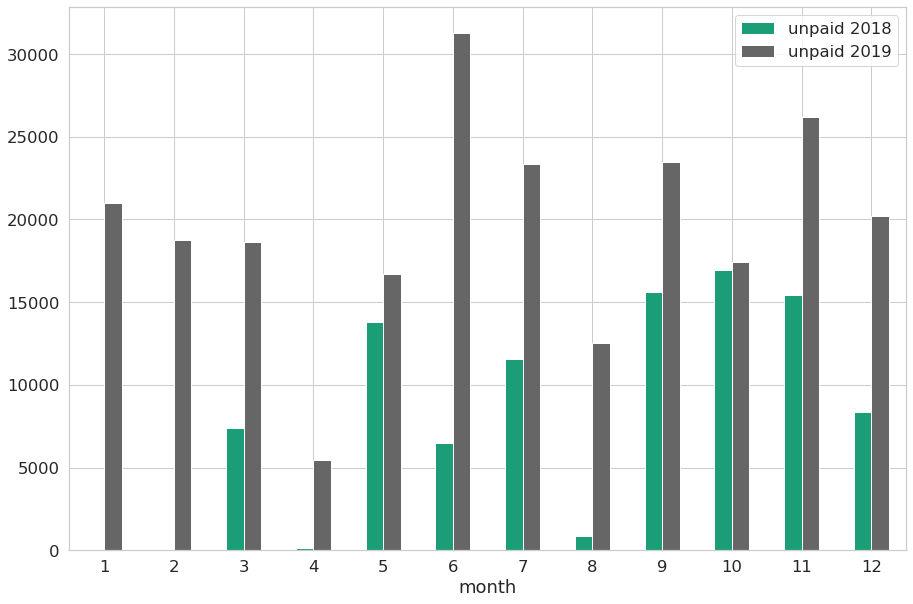

In [124]:
 
conn = getConnection()

sql = """with unpaid_query as( 
    select  d.year, d.month, sum(amount) unpaid  
    from installment  i 
    left join payment p on i.installment_key = p.installment_key 
    join customer c on sale_customer_key = c.customer_key 
    join npl n on i.sale_customer_key = n.sale_customer_key 
    join "date" d on i.due_date_key  = d.date_key 
    where payment_date_key is null  
    and i.due_date_key < 731 -- 31-12-2019 
    group by  d.year, d.month)  
SELECT up_2019.month, round(up_2018.unpaid,2) as  "unpaid 2018", 
                      round(up_2019.unpaid,2) as "unpaid 2019" 
FROM   
   (SELECT q.month, unpaid  
    FROM unpaid_query q 
    WHERE q.year = 2019) up_2019 
left join  
   (SELECT q.month, unpaid  
    FROM unpaid_query q 
    WHERE q.year = 2018) up_2018 
    ON up_2019.month = up_2018.month 
ORDER BY up_2019.month   """

df = sqlio.read_sql_query(sql, conn)
df = df.set_index('month')
conn.close()
df.head()
#df.plot(y=["2018", "2019"], kind="bar",figsize=(15,10), rot = 0)

df.plot.bar(figsize=(15,10), rot = 0,colormap='Dark2')



### Monthly status

In [129]:
 
conn = getConnection()

sql = """select month_end_Date, status, sum(c)/ sum(c) over (partition by month_end_Date) prop 

from ( 

    select month_end_Date,  count(*) c, 
    (case when npl.min_date_npl is null then 'BONIS' 
     when (month_end.date_key -npl.min_date_npl) > 365 then 'DEFAULT' 
     when (month_end.date_key -npl.min_date_npl) > 180 then 'UTP' 
     when (month_end.date_key -npl.min_date_npl) > 90 then 'PASTDUE' else 'BONIS' end) status 
    from sale s left outer join npl on   s.customer_key = npl.sale_customer_key, 
    (select max(date_key) as date_key, max(date) as month_end_Date 
    from "date" 
    group by year, month  
    HAVING max(date) < current_date 
    order by year, month ) month_end 
    WHERE s.sale_date_key < month_end.date_key 
    group by month_end_date, status 
    order by month_end_date, status ) df 
group by month_end_date, status, c 
order by month_end_date, status"""


df = sqlio.read_sql_query(sql, conn)
df = df.set_index('month_end_date')
normalizedDataFrame = df.div(df.sum(axis=1), axis=0);

color=(0.2, 0.4, 0.6, 0.6)

conn.close()
normalizedDataFrame.head()
#df.plot(y=["2018", "2019"], kind="bar",figsize=(15,10), rot = 0)

#df.plot.bar(figsize=(15,10), rot = 0)
normalizedDataFrame.plot.area(stacked=True,figsize=(15,10),ylim = [0.9,1], colormap='cividis');


TypeError: unsupported operand type(s) for /: 'str' and 'float'